# Handling different types of data

In this example we will show which types of experimental data can be handled by BME, and how they are handled.
From a practical point of view, the following datatypes are currently supported : NOE, chemical shifts (`CS`), scalar couplings (`JCOUPLINGS`), `SAXS` and `RDC`. This means that the keyword `DATA` in the experimental datafile has to be one of the following: `"NOE","JCOUPLINGS","CS","SAXS","RDC"`.


## Chemical shifts, 3J couplings and other *plain averaged* data 

Data such as chemical shifts are calculated as simple averages, i.e. 

$<F_{calc}> = \sum w_j F_{calc}(x_j)$

In this case, BME will try to find the weights such that $<F_{calc}> \approx F_{exp}$. 

## RDC: rescaling the dataset

For RDC the question is a little bit more complex, since 

$<F_{calc}> \approx \alpha F_{exp}$,  where $\alpha$ is a scaling parameter calculated by performing a linear regression (with intercept=0). The linear regression is weighted using the inverc
When using RDC it is #fundamental# to specify this when loading the data file


In [12]:
import sys,os
import numpy as np
bme_dir = os.getcwd().split("notebook")[0]
sys.path.append(bme_dir)
import BME as BME

# define input file names
exp_file = "%s/data/RDC_TL.exp.dat" % bme_dir
calc_file = "%s/data/RDC_TL.calc.dat.zip" % bme_dir

rew = BME.Reweight("example_03_scale")
# load the experimental and calculated datasets note the "scale" 
rew.load(exp_file,calc_file,fit="scale")
results = rew.fit(theta=100)

print("CHI2  original: %6.2f" % results[0])
print("CHI2 optimized: %6.2f" % results[1])

CHI2  original:  15.60
CHI2 optimized:   8.05


## SAXS: rescaled and shifted dataset

For SAXS data we need to scaled and shift the dataset. This means that 
$<F_{calc}> \approx \alpha F_{exp} + \beta$,  where $\alpha$ is a scaling parameter and $\beta$ is an offset.
These parameters are calculated by performing a linear regression. 

In [13]:
exp_file = "%s/data/saxs.exp.dat" % bme_dir
calc_file = "%s/data/saxs.calc.txt.zip" % bme_dir


# initialize. A name must be specified 
rew = BME.Reweight("example_03_scale_offset")

# load the experimental and calculated datasets
rew.load(exp_file,calc_file,fit="scale+offset")

results = rew.fit(theta=100)

print("CHI2  original: %6.2f" % results[0])
print("CHI2 optimized: %6.2f" % results[1])

CHI2  original:   4.77
CHI2 optimized:   2.05


## NOE: non linearly averaged data. 

The back-calculation of NOE involves averaging $r^{-p}$ distances, where $r$ is the distance between a proton pair and the exponent $p$ depends on the timescale of the internal motion.   Internally, BME will read all distances $r_j$ from the calculated datafile, and minimize the difference between $\sum_j w_j r_j^{-p}$ and $r_{EXP}^{-p}$. By default, BME will automatically perform this transformation (with $p=6$) whenever NOE data are loaded.  

In [16]:
exp_noe_file = "../data/NOE_exp.dat"
calc_noe_file = "../data/NOE_calc.dat.zip"

rew = BME.Reweight("example_03_noe")


rew.load(exp_noe_file,calc_noe_file)

results = rew.fit(theta=100)
print("CHI2  original: %6.2f" % results[0])
print("CHI2 optimized: %6.2f" % results[1])

CHI2  original:   1.15
CHI2 optimized:   0.77


Note that the $\chi^2$ above differs from the quantity that is calculated when calling the fucntion `predict()`. This is because the comparison is performed between $r_{calc} = (\sum_j w_j r_j^{-p})^{-1/p}$ and $r_{EXP}$

In [19]:
stats_noe = rew.predict(exp_noe_file,calc_noe_file,"example_03_noe")
print("CHI2  original: %6.2f" % stats_noe[0])
print("CHI2 optimized: %6.2f" % stats_noe[3])

print("RMSD  original: %6.2f" % stats_noe[1])
print("RMSD optimized: %6.2f" % stats_noe[4])

print("Violations  original: %d" % stats_noe[2])
print("Violations optimized: %d" % stats_noe[5])


CHI2  original:   3.15
CHI2 optimized:   1.82
RMSD  original:   0.44
RMSD optimized:   0.34
Violations  original: 16
Violations optimized: 9


This exponent $p$ can be chosen by passing the argument `averaging` to the load function. The allowed values are `"power_6","power_4","power_3"` or `"linear"`.

In [20]:
rew = BME.Reweight("example_03_noe_4")

# this automatically uses p=6
rew.load(exp_noe_file,calc_noe_file,averaging="power_4")

results = rew.fit(theta=100)
stats_noe = rew.predict(exp_noe_file,calc_noe_file,"example_03_noe4")
print("CHI2  original: %6.2f" % results[0])
print("CHI2 optimized: %6.2f" % results[1])



CHI2  original:   2.98
CHI2 optimized:   1.69


## Inequality restraints: upper and lower bounds. 

Sometimes experimental data comes in the form of upper or lower bound (e.g. NOE upper bounds or unobserved NOE). Such information can be specified in BME by adding the keyword `BOUND=UPPER` or `BOUND=LOWER` in the header of the experimental data file.
For example, when `DATA=LOWER`, BME will restrain the calculated averages to be above the value specified in the experimental data file. In the example below we use lower-bound NOE distances for reweighting:


In [8]:
%cat ../data/uNOE_exp.dat | head

# DATA=NOE BOUND=LOWER
C1_H1'_C2_H4' 5.2 0.1 
C1_H1'_C3_1H2' 5.2 0.1 
C1_H1'_C3_H3' 5.2 0.1 
C1_H1'_C3_H4' 5.2 0.1 
C1_H1'_C3_2H5' 5.2 0.1 
C1_H1'_C4_H3' 5.2 0.1 
C1_H1'_C4_H4' 5.2 0.1 
C1_H1'_C4_2H5' 5.2 0.1 
C1_1H2'_C3_1H2' 4.6 0.1 


In [21]:

rew = BME.Reweight("example_03_unoe")

exp_unoe_file = "../data/uNOE_exp.dat"
calc_unoe_file = "../data/uNOE_calc.dat.zip"
rew.load(exp_unoe_file,calc_unoe_file)

results = rew.fit(theta=100)
stats_unoe = rew.predict(exp_unoe_file,calc_unoe_file,"example_03_unoe")

print("CHI2  original: %6.2f" % stats_unoe[0])
print("CHI2 optimized: %6.2f" % stats_unoe[3])

print("RMSD  original: %6.2f" % stats_unoe[1])
print("RMSD optimized: %6.2f" % stats_unoe[4])

print("Violations  original: %d" % stats_unoe[2])
print("Violations optimized: %d" % stats_unoe[5])


CHI2  original:   4.32
CHI2 optimized:   0.01
RMSD  original:   0.21
RMSD optimized:   0.01
Violations  original: 13
Violations optimized: 1


We now plot the measurements that are violated in the original ensemble and/or in the optimized one

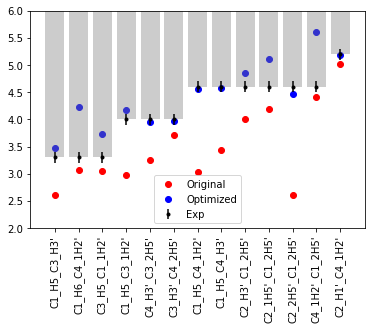

In [42]:
import matplotlib.pyplot as plt
results_data = np.loadtxt("example_03_unoe",usecols=(1,2,3,4,5))
labels = np.loadtxt("example_03_unoe",usecols=(0),dtype=str)

# select only the points that are violated 
ii = np.where(results_data[:,4]!=0)[0]
selection = results_data[ii,:]
labels_selection = labels[ii]

# order them to make the plot nicer
idx_ordered = np.argsort(selection[:,0])

xx = np.arange(len(idx_ordered))
#plt.errorbar(xx, selection[idx_ordered,0],selection[idx_ordered,1],c='k',fmt="o",label="Exp")
plt.bar(xx,[4]*len(xx),bottom=selection[idx_ordered,0],color='0.5',alpha=0.4)
plt.errorbar(xx, selection[idx_ordered,0],selection[idx_ordered,1],c='k',fmt=".",label="Exp")
plt.scatter(xx,selection[idx_ordered,2],c='r',label="Original")
plt.scatter(xx,selection[idx_ordered,3],c='b',label="Optimized")

plt.ylim(2,6)
_ = plt.xticks(xx,[labels_selection[l] for l in idx_ordered],rotation=90)
plt.legend()
#plt.plot(results_data[:])
